### Step 1: Initialize Spark Session and Load Data

**Explanation:**
This code block initializes a Spark session with the application name "Flight Delay Prediction". It then loads the data from `flights.csv` into a DataFrame `df`. This DataFrame automatically infers the schema of the CSV file based on its contents, which is important for ensuring that data types are correctly handled during processing. This step is crucial as it sets up the Spark environment and prepares the data for subsequent analysis and machine learning tasks.

In [23]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder \
    .appName("Flight Delay Prediction") \
    .getOrCreate()

# Load data
df = spark.read.csv("flights.csv", header=True, inferSchema=True)


### Step 2: Data Cleaning


**Explanation:**
This step focuses on cleaning the data to ensure its quality for analysis and model training:
- **Removing Missing Values:** Rows with missing values in 'DEPARTURE_DELAY' and 'SCHEDULED_DEPARTURE' are dropped. Missing values can lead to inaccurate predictions and analyses.
- **Type Conversion:** The 'DEPARTURE_DELAY' column is cast to a float type. Ensuring that data types are correct is crucial for modeling, as it affects how operations are performed on the data (e.g., mathematical operations for model training).

In [24]:
# Remove rows with missing values in critical columns
df = df.dropna(subset=["DEPARTURE_DELAY", "SCHEDULED_DEPARTURE"])

# Convert necessary columns to proper formats (if not already correct)
df = df.withColumn("DEPARTURE_DELAY", df["DEPARTURE_DELAY"].cast('float'))


### Step 3: Feature Engineering and Data Transformation


**Explanation:**
- **Binary Label Creation:** This line adds a new column 'label' to the DataFrame, where flights delayed by more than 15 minutes are marked as 1 (delayed) and others as 0 (not delayed). This binary label is used as the target variable for the logistic regression model.
- **Categorical Indexing:** The 'AIRLINE' and 'ORIGIN_AIRPORT' columns are treated as categorical variables. The `StringIndexer` converts these string values into numeric indices which are more suitable for modeling. A Spark `Pipeline` is used to streamline this transformation process. This step prepares the dataset by encoding categorical features, making it ready for use in machine learning algorithms.

In [25]:
# Creating a binary label for delay
df = df.withColumn("label", (df["DEPARTURE_DELAY"] > 15).cast("integer"))

# Indexing categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["AIRLINE", "ORIGIN_AIRPORT"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)


### Step 4: Assembling Features into a Single Vector

**Explanation:**
This step consolidates multiple feature columns into a single vector column named 'features' using the `VectorAssembler`. This transformation is critical for ML algorithms in Spark, which expect input data to be presented as a single features vector. The columns included in this vector are both numerical and categorical (already indexed), covering various aspects like time of flight and distance, which are relevant predictors for flight delays. This setup prepares the dataset for efficient machine learning processing.

In [26]:
assembler = VectorAssembler(
    inputCols=["MONTH", "DAY_OF_WEEK", "AIRLINE_index", "ORIGIN_AIRPORT_index", "SCHEDULED_DEPARTURE", "DISTANCE"],
    outputCol="features")
df = assembler.transform(df)


### Step 5: Model Training, Prediction, and Evaluation


**Explanation:**
- **Data Splitting:** The dataset is split into training (80%) and testing (20%) sets to evaluate the model's performance on unseen data.
- **Model Training:** A logistic regression model is instantiated and fitted to the training data. This model will learn to predict whether a flight will be delayed based on the features provided.
- **Model Prediction:** The trained model is used to make predictions on the test set.
- **Model Evaluation:** The model's performance is evaluated using the Area Under the ROC Curve (AUC), a common metric for binary classification problems that measures the ability of the model to distinguish between classes (delayed and not delayed flights). Higher AUC values indicate a better performing model.

In [27]:
# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Create the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Fit the model
model = lr.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.6334475072767852


### Step 6: Data Visualization - Average Flight Delay by Month


**Explanation:**
This code block visualizes the average flight delay by month:
- **Data Aggregation:** The data is grouped by the 'MONTH' column, and the mean 'DEPARTURE_DELAY' is calculated for each month.
- **Data Conversion:** The aggregated data is converted to a Pandas DataFrame to utilize Seaborn's plotting capabilities.
- **Plotting:** A bar chart is created using Seaborn, displaying the average delay for each month. This visualization helps in understanding seasonal trends in flight delays, providing insights into months with higher delays which could be crucial for operational planning and customer service enhancements.

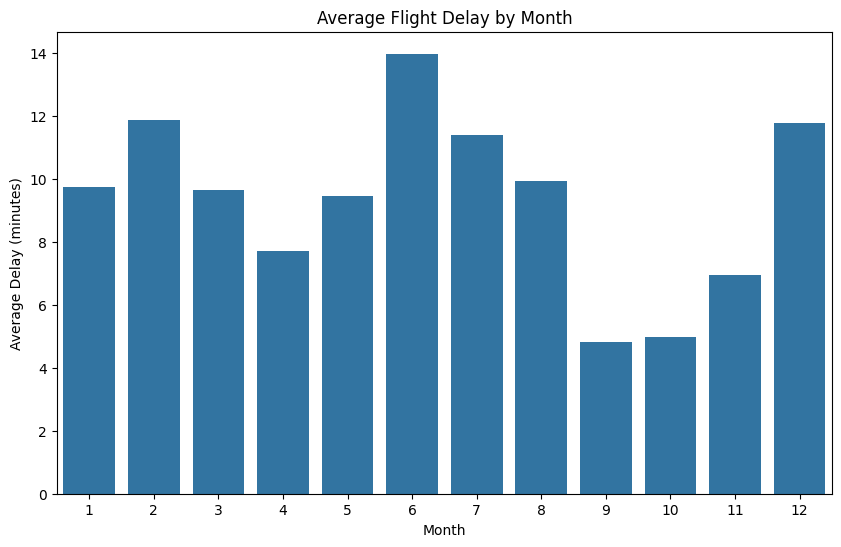

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by month and calculate average delay
monthly_delays = df.groupBy("MONTH").agg({'DEPARTURE_DELAY': 'mean'}).toPandas()
monthly_delays = monthly_delays.sort_values(by='MONTH')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='MONTH', y='avg(DEPARTURE_DELAY)', data=monthly_delays)
plt.title('Average Flight Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.show()


### Step 7: Data Visualization - Average Flight Delay by Airline


**Explanation:**
This code visualizes the average delays across different airlines:
- **Data Aggregation:** The DataFrame is grouped by 'AIRLINE', calculating the mean 'DEPARTURE_DELAY' for each airline, which helps identify which airlines frequently experience delays.
- **Data Conversion:** The results are converted into a Pandas DataFrame for better handling by plotting libraries.
- **Plotting:** A bar chart illustrates the average delays by airline, using Seaborn for visually appealing and informative graphics. This can highlight performance differences between airlines, useful for operational insights and consumer information.

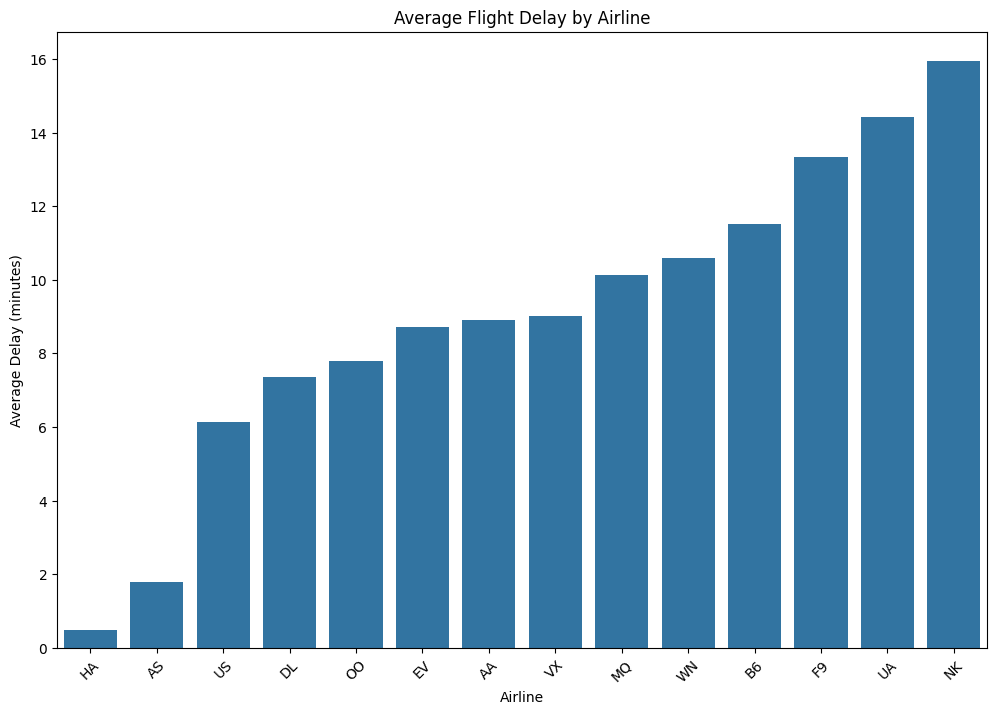

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
airline_delays = df.groupBy("AIRLINE").agg({'DEPARTURE_DELAY': 'mean'}).toPandas()
airline_delays = airline_delays.sort_values(by='avg(DEPARTURE_DELAY)')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='AIRLINE', y='avg(DEPARTURE_DELAY)', data=airline_delays)
plt.title('Average Flight Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


### Step 8: Model Evaluation and Timing

**Explanation:**
This step measures the performance of the logistic regression model across several metrics, crucial for understanding the effectiveness of the model:
- **ROC AUC:** Indicates the model's ability to discriminate between classes.
- **Accuracy, Precision, Recall, F1-Score:** These metrics provide a comprehensive view of the model's performance, especially useful when dealing with imbalanced datasets.
- **Timing:** Measures the total time taken for evaluation, providing insight into the computational efficiency of the model within the Spark environment.

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import time

start_time = time.time()
# Area Under ROC
evaluator_roc = BinaryClassificationEvaluator(metricName='areaUnderROC')
auc = evaluator_roc.evaluate(predictions)
print(f"Area Under ROC: {auc}")

# Accuracy, Precision, Recall, and F1-Score
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "precisionByLabel"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "recallByLabel"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
end_time_spark = time.time()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Time taken: {end_time_spark - start_time} seconds")


Area Under ROC: 0.6334461323380783


Accuracy: 0.821874323767774
Precision: 0.821874323767774
Recall: 1.0
F1-Score: 0.7415192093731222
Time taken: 17.60273790359497 seconds


### Step 9: Single-Threaded Application - Model Training and Evaluation


**Explanation:**
This code block represents the full process of a single-threaded Python application using pandas and scikit-learn to handle the flight delays dataset:
- **Data Loading and Preprocessing:** Reading the dataset, cleaning missing data, and setting up a binary target variable.
- **Feature Selection:** Using only relevant features for the logistic regression.
- **Model Training and Prediction:** Logistic regression model training on the training set and making predictions on the test set.
- **Evaluation:** Calculating accuracy and ROC AUC to assess the model performance.
- **Timing:** Capturing the total execution time from start to finish, allowing for performance comparison with the Spark implementation.

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import time

# Start the timer
start_time = time.time()

# Load the data
data = pd.read_csv('flights.csv')

# Data cleaning and preprocessing as per the steps described previously
data = data.dropna(subset=['DEPARTURE_DELAY'])
data['label'] = (data['DEPARTURE_DELAY'] > 15).astype(int)

# Feature engineering
features = data[['MONTH', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'DISTANCE']]
target = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluations
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

# End the timer
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time}s")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


/var/folders/v2/hp2thg1j43z__6fxrg793_qm0000gn/T/ipykernel_5753/288835389.py:11: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('flights.csv')


Execution Time: 14.455505847930908s
Accuracy: 0.8226543844072751
ROC AUC: 0.5



### Performance Metrics
- **Spark**:
  - **Area Under ROC:** 0.633
  - **Accuracy:** 0.822
  - **Precision:** 0.822
  - **Recall:** 1.0
  - **F1-Score:** 0.742
  - **Execution Time:** 17.6 seconds

- **Pandas**:
  - **Execution Time:** 14.5 seconds
  - **Accuracy:** 0.823
  - **ROC AUC:** 0.5

### Analysis
- **Execution Time**: Spark is slightly slower than Pandas. This might be due to Spark's overhead for managing distributed computing tasks, even if the dataset doesn't fully require distributed processing capabilities.
- **Accuracy and Precision**: Both models show similar accuracy and precision. However, the results are quite close, which indicates that for this specific task and dataset size, both frameworks perform comparably in terms of accuracy.
- **Recall and F1-Score**: Spark's recall is 1.0, suggesting it predicted all true positives correctly but may have many false positives (precision isn't perfect). This is reflected in the F1-score, which balances precision and recall and is lower than the accuracy.
- **ROC AUC**: The AUC for Spark is significantly higher than for Pandas, suggesting that Spark's model has a better measure of separability between classes. The low AUC for Pandas indicates poor model performance in distinguishing between classes.
  
### Conclusion
Spark shows a balanced performance in class discrimination but with a time penalty due to its distributed nature. The Pandas implementation, while faster, fails to effectively differentiate between classes, as indicated by the low ROC AUC value. This difference in ROC AUC might stem from differences in the implementation of the logistic regression model between the two platforms, or it might suggest a need to adjust model parameters or preprocessing steps in the Pandas implementation.